your 131072x1 screen size is bogus. expect trouble


22/12/15 11:14:46 WARN Utils: Your hostname, DESKTOP-QC3P089 resolves to a loopback address: 127.0.1.1; using 192.168.52.138 instead (on interface eth0)
22/12/15 11:14:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/johan/am111/am111_venv/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/johan/.ivy2/cache
The jars for the packages stored in: /home/johan/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7ea3a0f7-4c51-4e7c-abb5-43b560f89d18;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.2.4 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.15.0 in central
	found com.google.guava#guava;31.1-jre in central
	found com.google.guava#failurea

22/12/15 11:14:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


[*********************100%***********************]  1 of 1 completed
starting to load model


2022-12-15 11:15:13.610018: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


finished loading model
warc done
warc done
warc done
warc done
date not in stockdata 2022-12-15
date not in stockdata 2022-12-15
date not in stockdata 2022-12-15
date not in stockdata 2022-12-15
date not in stockdata 2022-12-15
date not in stockdata 2022-12-15
done one batch, size:  43
failures:  0


total positive and negatives for  2022-12-14
positives 1
negatives 42


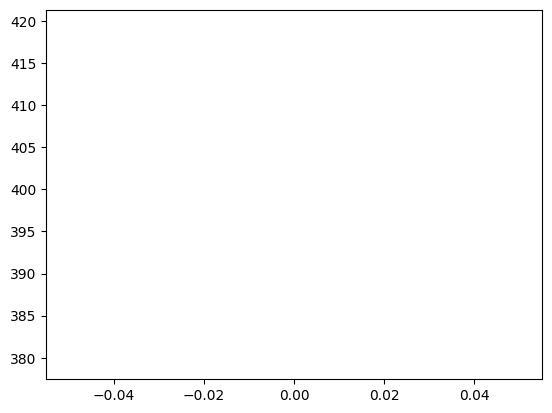

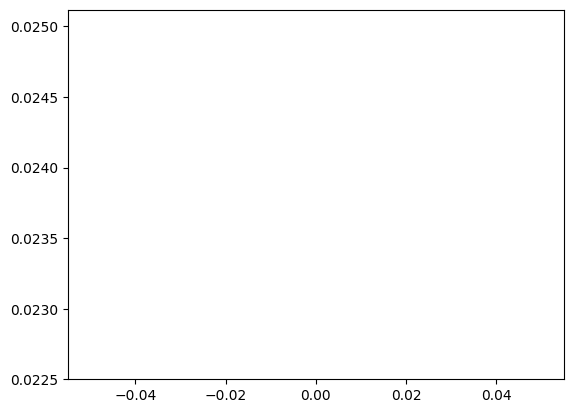

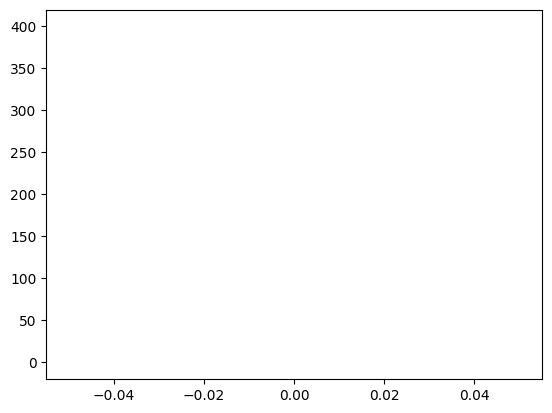

[0.023809523809523808]
[399.3999938964844]
['2022-12-14']


<Figure size 640x480 with 0 Axes>

In [1]:
'''
Usuage:
1.scp this file, requirements.txt, a model called model_dl inside models folder, and sentdat folder to the cluster, and the dockerfile and
training_fin_classfier.py to the cluster. 
Could scp everything but will take far longer, just scp everything but the parquet and make an empty parquet dir on the cluster.
2.make an empty dir called articlespar.parquet on the cluster
3.sudo build/run the dockerfile with -e PYTHONFILETORUN=./sentiment_long_optim.py, arguments go before the image name in run cmd
if running locally just build and run dockerfile but with additional arguments of (-e AWS_ACCESS_KEY_ID= -e AWS_SECRET_ACCESS_KEY=)
'''

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import StructType, StructField, StringType, LongType, IntegerType
import sparknlp
spark = sparknlp.start() 
# sparknlp.start(gpu=True) >> for training on GPU
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from langdetect import detect
from pyspark.sql.functions import col, lit, concat_ws

from sklearn.metrics import classification_report
import requests
from warcio import ArchiveIterator
from bs4 import BeautifulSoup
import time
import pandas as pd
import re
import yfinance as yf
import boto3
import botocore
import random
import sys 
import numpy as np
#PARAMETERS
path_dl_model = './models/model_dl'
batch_size_max = sys.maxsize -1
num_records_percrawl = 25 #number of recors to attempt to extract from each crawl
ticker = 'SPY'
#read in financewordlist.csv into the list
wordlist = pd.read_csv('./sentdat/topics.csv', header=None)[0].tolist()
wordlist.extend(yf.Ticker(ticker).info['longName'].split())
number_warcs_to_analyze = 10 #number of warcs to perform sentiment analysis on, goes from most reccent to farther back onse

#CREATING THE PIPELINE FOR LATER
document_assembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

sentence_detector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = Tokenizer() \
    .setInputCols(['sentence']) \
    .setOutputCol('token')

lemmatizer = Lemmatizer()\
    .setInputCols(['token'])\
    .setOutputCol('lemma')\
  .setDictionary("./sentdat/lemmas_small.txt", key_delimiter="->", value_delimiter="\t")
SentimentDetector = sentiment.SentimentDetector() \
    .setInputCols(['lemma', 'sentence'])\
    .setOutputCol('sentiment_score')\
    .setDictionary('./sentdat/sentiment-big.csv', ',')\

pipeline = Pipeline(stages=[
    document_assembler, 
    sentence_detector,
    tokenizer,
    lemmatizer,
    SentimentDetector
])
###GETTING WARC FILE NAMES FROM S3, GRABBING A RANDOM SAMPLE OF THEM
s3 = boto3.resource('s3')
my_bucket = s3.Bucket('commoncrawl')
warcs = []
for object in my_bucket.objects.filter(Prefix='crawl-data/CC-NEWS/'):
    if object.key.endswith('.warc.gz'):
        warcs.append(object.key)

warcs = random.sample(warcs, number_warcs_to_analyze) 

for index, warc in enumerate(warcs):
    warcs[index] = 'https://data.commoncrawl.org/' + warc

#function to convert time from commoncrawl format to y-m-d
def convert_header_date(date):
    return time.strftime('%Y-%m-%d', time.strptime(date, '%Y-%m-%dT%H:%M:%SZ'))


#obtaining stock data from yahoo finance from 2019 to current date.
currentdate = time.strftime("%Y-%m-%d")
stockdata = yf.download(ticker, start='2010-01-01', end=currentdate)['Adj Close']

#creating scehma to store text and prices
data = StructType([\
  StructField("text", StringType(), True),
    StructField("price", StringType(), True),
    StructField("date", StringType(), True)  
]
)

print('starting to load model')#TODO ADDE THESE PRINT STATEMENTS
FINDMODEL = PipelineModel.load(path_dl_model)
print('finished loading model')
#function to drop non-finance articles
def drop_nonfinance_articles(df):
  df = FINDMODEL.transform(df)
  df = df.withColumn('finance', df['financial_model_pred.result'].getItem(0).cast('float'))
  df = df.filter(df['finance'] == 1.0)
  return df

batching_done = False
pausing_index = 0
while batching_done == False: 
  # creating the main rdd to store the data
  list_of_rows_batch = []
  rows_batch_len = 0
  recordsfetched = 0
  failures = 0
  datelist = []

  for index, warc_url in enumerate(warcs):
      response = requests.get(warc_url, stream=True)
      if response.ok!=True:
          raise Exception("Error downloading WARC file")
      records = ArchiveIterator(response.raw, arc2warc=True)
      #what this should do is write each record's plaintexxt to a csv file
      for record in records:
          if record.rec_type == 'response':
              try: 
                  html = record.content_stream().read() .decode('utf-8')
                  plaintext = BeautifulSoup(html, 'lxml').get_text()
                  plaintext = re.sub(r'\s+', ' ', plaintext)
                  plaintext = re.sub(r'[^a-zA-Z0-9\s]', '', plaintext).lower()

                  #obtains plaintext from the html
                  if detect(plaintext) == 'en' and len(plaintext) > 150:  
                      date = record.rec_headers.get_header('WARC-Date')
                      date = convert_header_date(date)
                      # append the plaintext and price to the batch
                      if date in stockdata.index:
                          datelist.append(date)
                          list_of_rows_batch.append({'text':plaintext, 'price':float(stockdata[date]), 'date':date})
                          recordsfetched += 1
                          rows_batch_len += 1
                      else:
                          print('date not in stockdata',date)
                          #likely a weekend or holiday, so we will just skip the entire warc
                          break
                  else:
                      recordsfetched += 1                          
              except:
                  recordsfetched += 1  # because if the entire warc file is not in english or wrong date, we still want to move on to the next one
                  failures += 1
                  #print("attempt record: ", record.rec_headers.get_header('WARC-Target-URI'), " failed")
                  pass

          if rows_batch_len >= batch_size_max:
              print("batch size max reached")
              pausing_index = index

          if recordsfetched >= num_records_percrawl:
              recordsfetched = 0
              print("warc done")
              break

      #finishing up for the last batch in it wasn't full and num batches wasnt maxed out.
  if rows_batch_len > 0:
      datelist = np.unique(datelist)
      newdatelist = []
      for date in datelist:
         newdatelist.append(str(date)) #TODO ADJUSTED THIS
      datelist = newdatelist
      print("done one batch, size: ", rows_batch_len)
      rows_batch_len = 0

  if pausing_index != 0:
      warcs = warcs[pausing_index:]
      pausing_index = 0
  else:
      batching_done = True
  

  print("failures: ", failures)

  #now split list_of_rows_batch by dates in datelist
  
  list_of_lists_freach_date = [] #TODO adjust this
  for date in datelist:
      list_of_lists_freach_date.append([row for row in list_of_rows_batch if row['date'] == date])
  
    
  sentscores = []
  finacial_data = []

  for index, one_date_lst in enumerate(list_of_lists_freach_date):
    df = spark.createDataFrame(one_date_lst, schema=data)
    numarticles = len(one_date_lst)
    #dropping non-finance articles
    df = drop_nonfinance_articles(df)
    #drop unessecary columns created from dropping non-finance articles
    cols = df.columns
    for item in ['text', 'price', 'date']:
        cols.remove(item)
    df = df.drop(*cols)

    df = pipeline.fit(df).transform(df)

    df = df.withColumn("sentiment_score", concat_ws(",", "sentiment_score.result"))

    positives= df.filter(col('sentiment_score') == 'positive').count()
    negatives = numarticles - positives
    print("total positive and negatives for ", datelist[index])
    print("positives", positives)
    print("negatives", negatives)
    if negatives == 0:
      sentscores.append(positives)
    sentscores.append(positives/negatives)
    finacial_data.append(float(stockdata[datelist[index]]))



import matplotlib.pyplot as plt
x = np.arange(len(finacial_data))
plt.plot(x, finacial_data)
plt.show()
plt.plot(x, sentscores)
plt.show()
plt.plot(x, finacial_data)
plt.plot(x, sentscores)
plt.show()
plt.savefig('sentiment.png')

print(sentscores)
print(finacial_data)
print(datelist)

In [ ]:
type(datelist[0])

In [ ]:
one_date_lst

In [ ]:
list_of_lists_freach_date[:3]